# Titanic Kaggle Competition


In this notebook we're going to predict if a certain passenger of the titanic surived or not using machine learning.

This is a competition from kaggle, who provides the data to train, test and compare a submission

Data dictionary 

**PassengerId:**

**Pclass:** Ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd

**Name:** Name of the passenger

**Sex:** Sex

**Age:** Age

**SibSp:** Number of siblings or spouses aboard the Titanic

**Parch:** Number of parents aboard the Titanic

**Ticket:** Ticket number

**Fare:** Passenger fare

**Cabin:** Cabin number

**Embarked:** Port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

**Surived:** Did the passanger survived, this is the label, 0 = No, 1 = Yes

In [1]:
# Import the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [2]:
# Read the dataset
df = pd.read_csv('data/train.csv')

In [3]:
# Check the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA - Exploratory Data Analysis 

Size and shape of the dataset

In [4]:
df.shape

(891, 12)

Check some aggregates of the dataset

In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.corr()

C:\Users\Brahyam Almonte Ruiz\AppData\Local\Temp\ipykernel_17280\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [7]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Let's group the data by sex and print the counts and what kind of values Sex has 

In [9]:
df_group_sex = df.groupby('Sex').count()['PassengerId']
print(df_group_sex)

Sex
female    314
male      577
Name: PassengerId, dtype: int64


In [10]:
df_survived_group_sex = df['Sex'].loc[df['Survived'] == 1].value_counts()
df_survived_group_sex

female    233
male      109
Name: Sex, dtype: int64

Visualize this aggregate

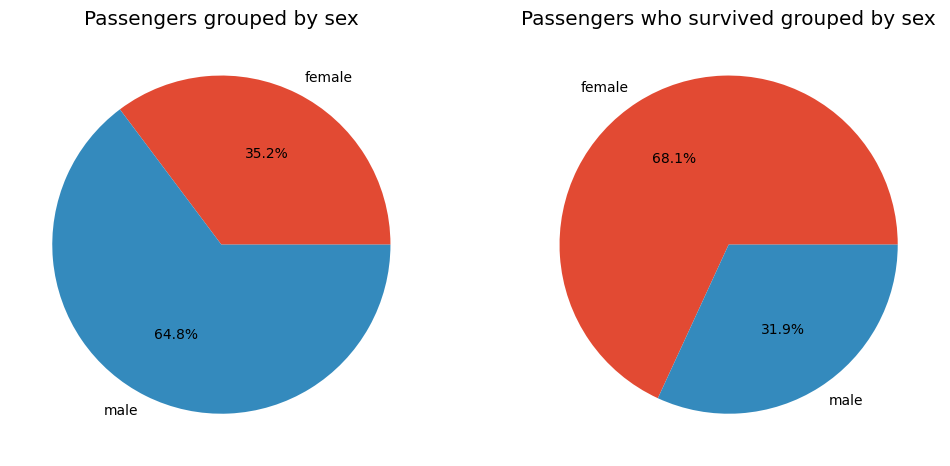

In [11]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].pie(df_group_sex, labels=df_group_sex.index, autopct='%.1f%%')
ax[0].set_title('Passengers grouped by sex')
ax[1].pie(df_survived_group_sex, labels=df_group_sex.index, autopct='%.1f%%')
ax[1].set_title('Passengers who survived grouped by sex')
plt.show()

Now by ticket class

In [12]:
df_group_class = df.groupby('Pclass').count()['PassengerId']
print(df_group_class)

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64


In [13]:
df_survived_group_class = df['Pclass'].loc[df['Survived'] == 1].value_counts()
df_survived_group_class

1    136
3    119
2     87
Name: Pclass, dtype: int64

Corresponding pie chart

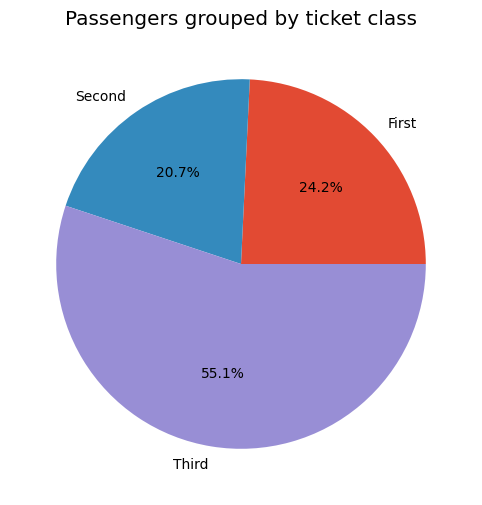

In [14]:
fig, ax = plt.subplots(1, 1, figsize= (12, 6))
ax.pie(df_group_class, labels=['First', 'Second', 'Third'], autopct='%.1f%%')
ax.set_title('Passengers grouped by ticket class')
plt.show()

## Data cleaning

Drop unique columns 

In [15]:
print(f'After dropping unique value columns: {df.shape}')
# df = df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
# print(f'After dropping unique value columns: {df.shape}')

After dropping unique value columns: (891, 12)


Check if there's any null or NaN (Not a Number) value in the dataset 

In [16]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Drop any rows with at least one column with null values

print(f'Before dropping rows: {df.shape}')
df = df.dropna()
print(f'After dropping rows: {df.shape}')

Check again, should be less

df.isnull().sum()

Scratch the upper cells, gonna test filling Age's null values with the median

In [17]:
df['Age'].loc[df['Age'] == 28]

23     28.0
34     28.0
83     28.0
100    28.0
105    28.0
169    28.0
200    28.0
281    28.0
313    28.0
342    28.0
355    28.0
392    28.0
399    28.0
403    28.0
423    28.0
426    28.0
430    28.0
443    28.0
508    28.0
562    28.0
635    28.0
756    28.0
848    28.0
874    28.0
883    28.0
Name: Age, dtype: float64

In [18]:
df['Age'].median()

28.0

In [19]:
df['Age'].fillna(df['Age'].median(), inplace=True)

In [20]:
df['Age'].loc[df['Age'] == 28]

5      28.0
17     28.0
19     28.0
23     28.0
26     28.0
       ... 
868    28.0
874    28.0
878    28.0
883    28.0
888    28.0
Name: Age, Length: 202, dtype: float64

In [21]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [22]:
embarked_common_value = df['Embarked'].value_counts().index[0]

In [23]:
df['Embarked'].fillna(embarked_common_value, inplace=True)

In [24]:
df['Cabin'].fillna('null', inplace=True)

In [25]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Feature Engineering

We can extract even more useful information from seemingly unique columns like name, ticket and cabin

- Name: Each person has a title in his name column we can extract this and use the new column in our predictions

In [26]:
df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [27]:
text = 'Braund, Mr. Owen Harris'

In [28]:
text.split(', ')[1].split('.')[0]

'Mr'

In [29]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [30]:
str(df['Name'].iloc[1]).split(', ')[1].split('.')[0]

'Mrs'

In [31]:
for i in range(df['Name'].shape[0]):
    print(str(df['Name'].iloc[i]).split(', ')[1].split('.')[0])
    if i > 20:
        break

Mr
Mrs
Miss
Mrs
Mr
Mr
Mr
Master
Mrs
Mrs
Miss
Miss
Mr
Mr
Miss
Mrs
Master
Mr
Mrs
Mrs
Mr
Mr


In [32]:
df['Title'] = np.nan
for i in range(df['Name'].shape[0]):
    df['Title'].iloc[i] = str(df['Name'].iloc[i]).split(', ')[1].split('.')[0]

C:\Users\Brahyam Almonte Ruiz\AppData\Local\Temp\ipykernel_17280\1836765641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Title'].iloc[i] = str(df['Name'].iloc[i]).split(', ')[1].split('.')[0]


In [33]:
df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [34]:
df['Cabin'].value_counts()

null           687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

In [35]:
df['Cabin'].iloc[1][0]

'C'

In [36]:
df['Cabin'].isnull()[0]

False

In [37]:
df['Cabin_Letter'] = np.nan
for i in range(df['Cabin'].shape[0]):
    if df['Cabin'].isnull()[i] == False:
        df['Cabin_Letter'].iloc[i] = df['Cabin'].iloc[i][0]

C:\Users\Brahyam Almonte Ruiz\AppData\Local\Temp\ipykernel_17280\1480018329.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cabin_Letter'].iloc[i] = df['Cabin'].iloc[i][0]


In [38]:
df['Cabin_Letter'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [39]:
df.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
Title           0
Cabin_Letter    0
dtype: int64

In [40]:
df['Ticket'].value_counts().sort_index(ascending=False)

WE/P 5735      2
W/C 14208      1
W.E.P. 5734    1
W./C. 6609     1
W./C. 6608     4
              ..
110813         1
110564         1
110465         2
110413         3
110152         3
Name: Ticket, Length: 681, dtype: int64

## Data transformation

Let's check again the ranges of the numerical data

In [41]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age and Fare have a big range of values we should normalize the data by removing the mean and dividing the value by the standard deviation

In [42]:
df['Age'].shape

(891,)

We need to passthrough a (n, n) array to the scaler not an (n,) array, so we're going to reshape the pandas series with `df['Age'].values.reshape((-1,1))`

In [43]:
age_scaler = StandardScaler()
fare_scaler = StandardScaler()
df['Age'] = age_scaler.fit_transform(df['Age'].values.reshape(-1, 1))
df['Fare'] = fare_scaler.fit_transform(df['Fare'].values.reshape(-1, 1))

Check the results, Age and Fare should be a value between 1 and -1 

In [44]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Letter
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.565736,1,0,A/5 21171,-0.502445,null,S,Mr,n
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.663861,1,0,PC 17599,0.786845,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.258337,0,0,STON/O2. 3101282,-0.488854,null,S,Miss,n
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.433312,1,0,113803,0.420730,C123,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,0.433312,0,0,373450,-0.486337,null,S,Mr,n


The 'Sex' and 'Embarked' columns are categorical features we should encode them in order to use them, first let's check the values

In [45]:
print(f'Sex Column: \n{df.Sex.value_counts()}\n')
print(f'Embarked Column: \n{df.Embarked.value_counts()}\n')
print(f'Title Column: \n{df.Title.value_counts()}\n')
print(f'Cabin_Letter Column: \n{df.Embarked.value_counts()}')

Sex Column: 
male      577
female    314
Name: Sex, dtype: int64

Embarked Column: 
S    646
C    168
Q     77
Name: Embarked, dtype: int64

Title Column: 
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Cabin_Letter Column: 
S    646
C    168
Q     77
Name: Embarked, dtype: int64


Now let's encode the Sex and Embarked values as Binary and Label Enconded columns, in order to make the value male -> 0 and female -> 1, and the same with all embarked values

In [46]:
# Create the encoders based on the LabelEncoder class from tensorflow 
sex_encoder = LabelEncoder()
embarked_encoder = LabelEncoder()
title_encoder = LabelEncoder()
cabin_letter_encoder = LabelEncoder()
# Fit(configure the encoder) and transform(actually make the changes) in a single step
df['Sex'] = sex_encoder.fit_transform(df['Sex'])
df['Embarked'] = embarked_encoder.fit_transform(df['Embarked'])
df['Title'] = title_encoder.fit_transform(df['Title'])
df['Cabin_Letter'] = cabin_letter_encoder.fit_transform(df['Cabin_Letter'])

In order to understand the values, let's create some variables based in the encoders

In [47]:
sex_encoder_classes = sex_encoder.classes_
embarked_encoder_classes = embarked_encoder.classes_
title_encoder_classes = title_encoder.classes_
sex_encoder_values = sex_encoder.transform(list(sex_encoder.classes_))
embarked_encoder_values = embarked_encoder.transform(list(embarked_encoder.classes_))
title_encoder_values = title_encoder.transform(list(title_encoder.classes_))

In [48]:
print(f'Original Sex values: {sex_encoder_classes}\nEnconded Sex values: {sex_encoder_values}')
print(f'Original Embarked values: {embarked_encoder_classes}\nEnconded Embarked values: {embarked_encoder_values}')
print(f'Original Title values: {title_encoder_classes}\nEnconded Title values: {title_encoder_values}')

Original Sex values: ['female' 'male']
Enconded Sex values: [0 1]
Original Embarked values: ['C' 'Q' 'S']
Enconded Embarked values: [0 1 2]
Original Title values: ['Capt' 'Col' 'Don' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master' 'Miss' 'Mlle'
 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir' 'the Countess']
Enconded Title values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Let's create two dictionaries with the corresponding values

In [49]:
sex_encoder_dict = {}
for i in range(len(sex_encoder_classes)):
    sex_encoder_dict[sex_encoder_classes[i]] = sex_encoder_values[i]
sex_encoder_dict

{'female': 0, 'male': 1}

In [50]:
embarked_encoder_dict = {}
for i in range(len(embarked_encoder_classes)):
    embarked_encoder_dict[embarked_encoder_classes[i]] = embarked_encoder_values[i]
embarked_encoder_dict

{'C': 0, 'Q': 1, 'S': 2}

Check our final dataframe 

In [51]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Letter
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.565736,1,0,A/5 21171,-0.502445,null,2,11,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.663861,1,0,PC 17599,0.786845,C85,0,12,2
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.258337,0,0,STON/O2. 3101282,-0.488854,null,2,8,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.433312,1,0,113803,0.420730,C123,2,12,2
4,5,0,3,"Allen, Mr. William Henry",1,0.433312,0,0,373450,-0.486337,null,2,11,8


In [52]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex               int32
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked          int32
Title             int32
Cabin_Letter      int32
dtype: object

## Build the Model

We need to separate the features from the label or target 

In [53]:
# List all the columns
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title',
       'Cabin_Letter'],
      dtype='object')

Create the two lists and with them, the two dataframes

In [54]:
# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Cabin_Letter']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Title', 'Cabin_Letter']
label = 'Survived'

The x dataframe contains the features and the y dataframe the labels 

In [55]:
x = df[features]
y = df[label]

Split each dataframe in 3 parts, train, cross validation and test 

In [56]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1, shuffle=True)
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1, shuffle=True)
print("X_train.shape", x_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", x_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", x_test.shape, "y_test.shape", y_test.shape)

X_train.shape (534, 9) y_train.shape (534,)
X_cv.shape (178, 9) y_cv.shape (178,)
X_test.shape (179, 9) y_test.shape (179,)


In [57]:
# model = XGBClassifier(n_estimators=400, learning_rate=0.1, verbosity=1, random_state=1, early_stopping_rounds=160)

model.fit(x_train, y_train, eval_set=[(x_cv, y_cv)])

[0]	validation_0-logloss:0.64544
[1]	validation_0-logloss:0.60476
[2]	validation_0-logloss:0.57360
[3]	validation_0-logloss:0.54830
[4]	validation_0-logloss:0.52629
[5]	validation_0-logloss:0.51015
[6]	validation_0-logloss:0.49616
[7]	validation_0-logloss:0.48537
[8]	validation_0-logloss:0.47454
[9]	validation_0-logloss:0.46770
[10]	validation_0-logloss:0.46218
[11]	validation_0-logloss:0.45736
[12]	validation_0-logloss:0.45406
[13]	validation_0-logloss:0.45000
[14]	validation_0-logloss:0.44681
[15]	validation_0-logloss:0.44361
[16]	validation_0-logloss:0.44110
[17]	validation_0-logloss:0.44021
[18]	validation_0-logloss:0.43868
[19]	validation_0-logloss:0.43888
[20]	validation_0-logloss:0.43586
[21]	validation_0-logloss:0.43370
[22]	validation_0-logloss:0.43199
[23]	validation_0-logloss:0.43001
[24]	validation_0-logloss:0.42811
[25]	validation_0-logloss:0.42835
[26]	validation_0-logloss:0.42805
[27]	validation_0-logloss:0.42702
[28]	validation_0-logloss:0.42755
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=160,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [58]:
print(f'Best iteration: {model.best_iteration} \nlogistic loss score: {model.best_score}')

Best iteration: 27 
logistic loss score: 0.4270190494030379


In [59]:
print('Metrics')
print(f'Accuracy in the train dataset: {accuracy_score(model.predict(x_train), y_train)}')
print(f'Accuracy in the cross validation dataset: {accuracy_score(model.predict(x_cv), y_cv)}')
print(f'Accuracy in the test dataset: {accuracy_score(model.predict(x_test), y_test)}')
print(f'Confusion matrix of the test dataset:\n{confusion_matrix(y_test, model.predict(x_test))}')
print(f'Mean Squared Error: {mean_squared_error(y_test, model.predict(x_test))}')
print(f'F1 Score: {f1_score(y_test, model.predict(x_test))}')
print(f'Precision Score: {precision_score(y_test, model.predict(x_test))}')
print(f'Recall Score: {recall_score(y_test, model.predict(x_test))}')
print(f'Precision, Recall, f1_score: {precision_recall_fscore_support(y_test, model.predict(x_test))}')

Metrics
Accuracy in the train dataset: 0.9138576779026217
Accuracy in the cross validation dataset: 0.8089887640449438
Accuracy in the test dataset: 0.776536312849162
Confusion matrix of the test dataset:
[[86  7]
 [33 53]]
Mean Squared Error: 0.22346368715083798
F1 Score: 0.7260273972602739
Precision Score: 0.8833333333333333
Recall Score: 0.6162790697674418
Precision, Recall, f1_score: (array([0.72268908, 0.88333333]), array([0.92473118, 0.61627907]), array([0.81132075, 0.7260274 ]), array([93, 86], dtype=int64))


Let's try it without a cross validation set: 

In [60]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)
# x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1, shuffle=True)
print("X_train.shape", x_train.shape, "y_train.shape", y_train.shape)
# print("X_cv.shape", x_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", x_.shape, "y_test.shape", y_.shape)

X_train.shape (712, 9) y_train.shape (712,)
X_test.shape (179, 9) y_test.shape (179,)


In [61]:
model_no_cv = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1, random_state=1, early_stopping_rounds=160)
model_no_cv.fit(x_train, y_train, eval_set=[(x_, y_)])

[0]	validation_0-logloss:0.65177
[1]	validation_0-logloss:0.61767
[2]	validation_0-logloss:0.59065
[3]	validation_0-logloss:0.56710
[4]	validation_0-logloss:0.54884
[5]	validation_0-logloss:0.53203
[6]	validation_0-logloss:0.51877
[7]	validation_0-logloss:0.50689
[8]	validation_0-logloss:0.49763
[9]	validation_0-logloss:0.49038
[10]	validation_0-logloss:0.48381
[11]	validation_0-logloss:0.48063
[12]	validation_0-logloss:0.47388
[13]	validation_0-logloss:0.47013
[14]	validation_0-logloss:0.46742
[15]	validation_0-logloss:0.46618
[16]	validation_0-logloss:0.46602
[17]	validation_0-logloss:0.46481
[18]	validation_0-logloss:0.46272
[19]	validation_0-logloss:0.46240
[20]	validation_0-logloss:0.46144
[21]	validation_0-logloss:0.46329
[22]	validation_0-logloss:0.46473
[23]	validation_0-logloss:0.46408
[24]	validation_0-logloss:0.46766
[25]	validation_0-logloss:0.46969
[26]	validation_0-logloss:0.47195
[27]	validation_0-logloss:0.47190
[28]	validation_0-logloss:0.47478
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=160,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [62]:
model_no_cv.best_iteration

20

In [63]:
model_no_cv.best_score

0.4614405567502842

In [64]:
print('Metrics')
print(f'Accuracy in the train dataset: {accuracy_score(model_no_cv.predict(x_train), y_train)}')
# print(f'Accuracy in the cross validation dataset: {accuracy_score(model_no_cv.predict(x_cv), y_cv)}')
print(f'Accuracy in the test dataset: {accuracy_score(model_no_cv.predict(x_), y_)}')
print(f'Confusion matrix of the test dataset:\n{confusion_matrix(y_, model_no_cv.predict(x_))}')
print(f'Mean Squared Error: {mean_squared_error(y_, model_no_cv.predict(x_))}')
print(f'F1 Score: {f1_score(y_, model_no_cv.predict(x_))}')
print(f'Precision Score: {precision_score(y_, model_no_cv.predict(x_))}')
print(f'Recall Score: {recall_score(y_, model_no_cv.predict(x_))}')
print(f'Precision, Recall, f1_score: {precision_recall_fscore_support(y_, model_no_cv.predict(x_))}')

Metrics
Accuracy in the train dataset: 0.9044943820224719
Accuracy in the test dataset: 0.7821229050279329
Confusion matrix of the test dataset:
[[97  9]
 [30 43]]
Mean Squared Error: 0.21787709497206703
F1 Score: 0.6880000000000001
Precision Score: 0.8269230769230769
Recall Score: 0.589041095890411
Precision, Recall, f1_score: (array([0.76377953, 0.82692308]), array([0.91509434, 0.5890411 ]), array([0.83261803, 0.688     ]), array([106,  73], dtype=int64))


##  Prepare and submit the model

First, we need to know what we should upload to kaggle 

In [65]:
df_example = pd.read_csv('data/gender_submission.csv')
df_example.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


So we're going to submit a .csv file with only two columns the PassengerId and the prediciton 

In [66]:
df_target = pd.read_csv('data/test.csv')

In [67]:
df_target.shape

(418, 11)

In [68]:
df_target.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [69]:
df_target['Age'].fillna(df['Age'].median(), inplace=True)
df_target['Cabin'].fillna('null', inplace=True)
df_target['Fare'].fillna(df['Fare'].mean(), inplace=True)

In [70]:
df_target['Title'] = np.nan
for i in range(df_target['Name'].shape[0]):
    df_target['Title'].iloc[i] = str(df_target['Name'].iloc[i]).split(', ')[1].split('.')[0]

C:\Users\Brahyam Almonte Ruiz\AppData\Local\Temp\ipykernel_17280\2890098460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Title'].iloc[i] = str(df_target['Name'].iloc[i]).split(', ')[1].split('.')[0]


In [71]:
df_target['Cabin_Letter'] = np.nan
for i in range(df_target['Cabin'].shape[0]):
    if df_target['Cabin'].isnull()[i] == False:
        df_target['Cabin_Letter'].iloc[i] = df_target['Cabin'].iloc[i][0]

C:\Users\Brahyam Almonte Ruiz\AppData\Local\Temp\ipykernel_17280\3195870300.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Cabin_Letter'].iloc[i] = df_target['Cabin'].iloc[i][0]


In [72]:
# age_scaler = StandardScaler()
# fare_scaler = StandardScaler()
df_target['Age'] = age_scaler.transform(df_target['Age'].values.reshape(-1, 1))
df_target['Fare'] = fare_scaler.transform(df_target['Fare'].values.reshape(-1, 1))

In [73]:
# ex_encoder = LabelEncoder()
# embarked_encoder = LabelEncoder()
# title_encoder = LabelEncoder()
# cabin_letter_encoder = LabelEncoder()
title_encoder.classes_ = list(title_encoder.classes_) + ['Dona']
title_encoder.classes_

['Capt',
 'Col',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess',
 'Dona']

In [74]:
df_target['Sex'] = sex_encoder.transform(df_target['Sex'])
df_target['Embarked'] = embarked_encoder.transform(df_target['Embarked'])
df_target['Title'] = title_encoder.transform(df_target['Title'])
df_target['Cabin_Letter'] = cabin_letter_encoder.transform(df_target['Cabin_Letter'])

In [75]:
df_target[features].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_Letter
0,3,1,0.394887,0,0,-0.490783,1,11,8
1,3,0,1.355510,1,0,-0.507479,2,12,8
2,2,1,2.508257,0,0,-0.453367,1,11,8
3,3,1,-0.181487,0,0,-0.474005,2,11,8
4,3,0,-0.565736,1,1,-0.401017,2,12,8


In [76]:
survived = pd.Series(model.predict(df_target[features]), name='Survived')
survived

0      0
1      0
2      0
3      0
4      1
      ..
413    1
414    1
415    0
416    1
417    1
Name: Survived, Length: 418, dtype: int32

In [77]:
df_solution = pd.merge(df_target['PassengerId'], survived, left_index=True, right_index=True)

In [78]:
df_solution.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [79]:
df_solution.to_csv('data/submission.csv', index=False)